In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Form Dataframe

In [132]:
lexical_df = pd.read_csv('D:\MLPR\MIT_INTERVIEW_DATASET\Labels\interview_transcripts_by_turkers.csv', header=None)
lexical_df.columns = ['InterviewID', 'Transcript']
lexical_df['InterviewID'] = lexical_df['InterviewID'].str.upper()
lexical_df.head()

,InterviewID,Transcript
0,P1,Interviewer: So how are you doing?|Interviewee...
1,P10,Interviewer: So how you doing?|Interviewee: G...
2,P11,Interviewer: So tell me about yourself. |Inte...
3,P12,Interviewer: So how are you doing today?|Inter...
4,P13,Interviewer: How are you doing today?|Intervie...


In [133]:
interviewee_responses = {}

# Iterate through the dataframe rows
for index, row in lexical_df.iterrows():
    transcript = row['Transcript']

    # Split the transcript into interview segments
    segments = transcript.split('|')

    # Extract interviewee responses
    interviewee_response = ""
    for segment in segments:
        if 'Interviewee:' in segment:
            interviewee_response += segment.replace('Interviewee:', '').strip() + " "

    # Append interviewee response to the list
    interviewee_responses[row['InterviewID']] = interviewee_response



In [134]:
interviewee_responses_df = pd.DataFrame.from_dict(interviewee_responses, orient='index')
interviewee_responses_df.columns = ['Transcript']
interviewee_responses_df.reset_index(level=0, inplace=True)
interviewee_responses_df.columns = ['InterviewID', 'Transcript']
interviewee_responses_df.head()

,InterviewID,Transcript
0,P1,Im pretty good. ok uhm so have you looked at...
1,P10,Great how about you? I'm a little [???] by th...
2,P11,Uhh I’m a junior at MIT uhh I’m double major...
3,P12,I'm good how are you? Ok so I'm a Junior at...
4,P13,Good. Ok umm I'm currently a junior at M.I.T...


In [135]:
df_labels = pd.read_csv('D:\MLPR\MIT_INTERVIEW_DATASET\Labels\\turker_scores_full_interview.csv')
df_labels = df_labels.rename(columns={'Participant': 'InterviewID'})
df_labels = df_labels.drop(columns=['Worker'])
df_labels = df_labels.groupby('InterviewID').mean().reset_index()
df_labels['InterviewID'] = df_labels['InterviewID'].str.upper()

medians = df_labels.median(numeric_only=True)

In [136]:
import pandas as pd

# Assuming df_labels and medians are defined before this code snippet

labels_to_process = ['Overall', 'RecommendHiring', 'Colleague', 'Engaged', 'Excited', 'EyeContact', 'Smiled',
                     'SpeakingRate', 'NoFillers', 'Friendly', 'Paused', 'EngagingTone', 'StructuredAnswers',
                     'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward', 'Total']

classify = {}
ids = df_labels['InterviewID']

for label in labels_to_process:
    for i in ids:
        if df_labels[df_labels['InterviewID'] == i][label].values[0] >= medians[label]:
            classify.setdefault(i, {})[label] = True
        else:
            classify.setdefault(i, {})[label] = False

classify_df = pd.DataFrame.from_dict(classify, orient='index')
classify_df.reset_index(level=0, inplace=True)
classify_df = classify_df.rename(columns={'index': 'InterviewID'})

# If you want to replace NaN values with False for labels that were not processed in the loop
classify_df = classify_df.fillna(False)

classify_df.head()

,InterviewID,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total
0,P1,True,True,True,True,True,True,False,True,False,False,True,True,True,False,False,True,False,True,False
1,P10,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False
2,P11,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False
3,P12,True,True,True,True,True,False,True,True,True,True,False,True,False,True,True,False,True,False,True
4,P13,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,True,False,False,False


In [137]:
# merge the two dataframes
df = pd.merge(interviewee_responses_df, classify_df, on='InterviewID')
df.head()

,InterviewID,Transcript,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,...,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total
0,P1,Im pretty good. ok uhm so have you looked at...,True,True,True,True,True,True,False,True,...,False,True,True,True,False,False,True,False,True,False
1,P10,Great how about you? I'm a little [???] by th...,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,False
2,P11,Uhh I’m a junior at MIT uhh I’m double major...,False,False,False,False,False,False,False,True,...,False,True,False,True,False,False,True,False,False,False
3,P12,I'm good how are you? Ok so I'm a Junior at...,True,True,True,True,True,False,True,True,...,True,False,True,False,True,True,False,True,False,True
4,P13,Good. Ok umm I'm currently a junior at M.I.T...,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,False


# Visualize Dataframe

### Structured = True

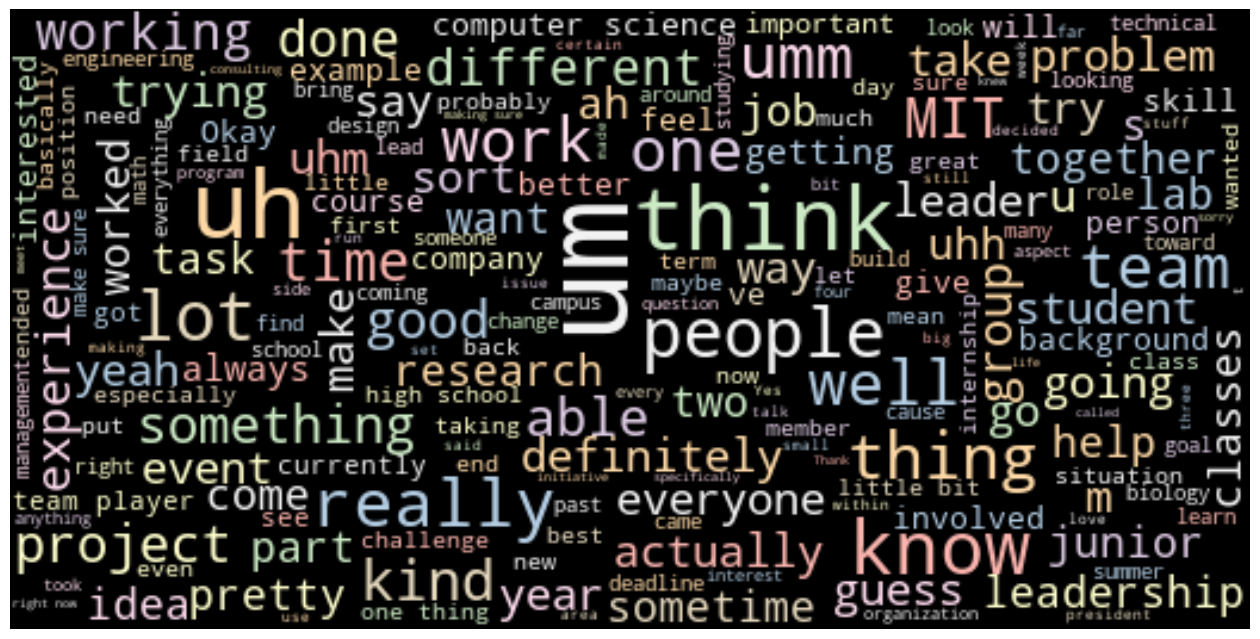

In [138]:
structured_true = " ".join(msg for msg in df[df['StructuredAnswers'] == True].Transcript)
structured_true_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(structured_true)
plt.figure(figsize=(16,10))
plt.imshow(structured_true_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

### Structured = False

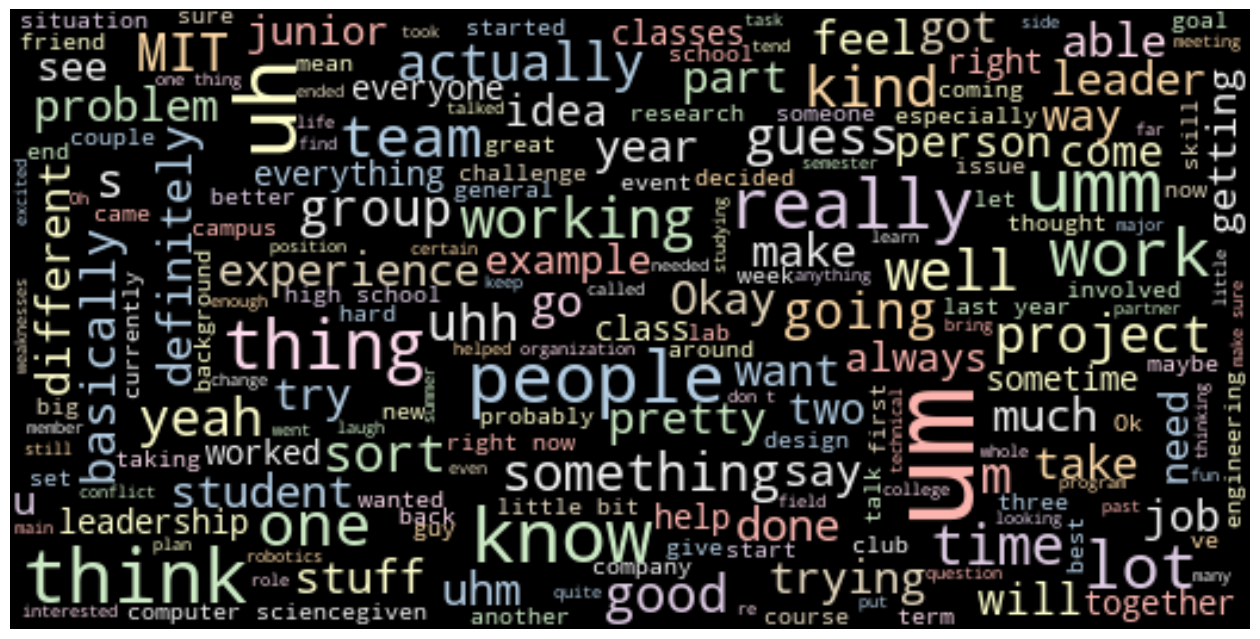

In [139]:
structured_false = " ".join(msg for msg in df[df['StructuredAnswers'] == False].Transcript)
structured_false_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(structured_false)
plt.figure(figsize=(16,10))
plt.imshow(structured_false_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

In [140]:
df['text_length'] = df['Transcript'].apply(len)
df.head()

,InterviewID,Transcript,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,...,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,text_length
0,P1,Im pretty good. ok uhm so have you looked at...,True,True,True,True,True,True,False,True,...,True,True,True,False,False,True,False,True,False,2762
1,P10,Great how about you? I'm a little [???] by th...,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,5305
2,P11,Uhh I’m a junior at MIT uhh I’m double major...,False,False,False,False,False,False,False,True,...,True,False,True,False,False,True,False,False,False,3639
3,P12,I'm good how are you? Ok so I'm a Junior at...,True,True,True,True,True,False,True,True,...,False,True,False,True,True,False,True,False,True,2977
4,P13,Good. Ok umm I'm currently a junior at M.I.T...,False,False,False,False,False,False,False,False,...,True,False,True,True,False,True,False,False,False,3111


In [141]:
X_train, X_test, y_train, y_test = train_test_split(df['Transcript'], df['StructuredAnswers'], test_size=0.4, random_state=42)

In [142]:
# Defining pre-processing parameters
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [143]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [144]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4129

In [145]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)


In [146]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [147]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (82, 50)
Shape of testing tensor:  (56, 50)


In [172]:
embedding_dim = 16
drop_value = 0.2
n_dense = 24
drop_lstm = 0.2
n_lstm = 256
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=10)

### Dense Model

In [173]:
def create_dense_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, embedding_dim, input_length=max_len))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(24, activation='relu'))
    model.add(Dropout(drop_value))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### LSTM

In [174]:
def create_lstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(drop_lstm))
    model.add(LSTM(n_lstm, return_sequences=False))
    model.add(Dropout(drop_lstm))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Bi-LSTM

In [175]:
def create_bi_lstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(n_lstm, return_sequences=False)))
    model.add(Dropout(drop_lstm))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### GRU

In [176]:
def create_gru_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Train and Evaluate

In [177]:
def train_and_evaluate_model(model, label):
    X_train, X_test, y_train, y_test = train_test_split(df['Transcript'], df[label], test_size=0.4, random_state=42)

    tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    training_sequences = tokenizer.texts_to_sequences(X_train)
    training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    testing_sequences = tokenizer.texts_to_sequences(X_test)
    testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),
                        callbacks=[early_stop], verbose=2)

    loss, accuracy = model.evaluate(testing_padded, y_test)
    return accuracy


In [178]:
# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['label', 'Dense accuracy', 'LSTM accuracy', 'Bi-LSTM accuracy', 'GRU accuracy'])

# Loop through each label
for label in labels_to_process:
    label_results = {'label': label}

    # Train and evaluate Dense model
    dense_model = create_dense_model(total_words)
    label_results['Dense accuracy'] = train_and_evaluate_model(dense_model, label)

    # Train and evaluate LSTM model
    lstm_model = create_lstm_model(total_words)
    label_results['LSTM accuracy'] = train_and_evaluate_model(lstm_model, label)

    # Train and evaluate Bi-LSTM model
    bi_lstm_model = create_bi_lstm_model(total_words)
    label_results['Bi-LSTM accuracy'] = train_and_evaluate_model(bi_lstm_model, label)

    # Train and evaluate GRU model
    gru_model = create_gru_model(total_words)
    label_results['GRU accuracy'] = train_and_evaluate_model(gru_model, label)

    results_df = pd.concat([results_df, pd.DataFrame([label_results])], ignore_index=True)

Epoch 1/30
3/3 - 2s - loss: 0.6930 - accuracy: 0.5122 - val_loss: 0.6938 - val_accuracy: 0.4286 - 2s/epoch - 555ms/step
Epoch 2/30
3/3 - 0s - loss: 0.6913 - accuracy: 0.5488 - val_loss: 0.6947 - val_accuracy: 0.4286 - 90ms/epoch - 30ms/step
Epoch 3/30
3/3 - 0s - loss: 0.6897 - accuracy: 0.5488 - val_loss: 0.6953 - val_accuracy: 0.4286 - 81ms/epoch - 27ms/step
Epoch 4/30
3/3 - 0s - loss: 0.6889 - accuracy: 0.5488 - val_loss: 0.6961 - val_accuracy: 0.4286 - 73ms/epoch - 24ms/step
Epoch 5/30
3/3 - 0s - loss: 0.6872 - accuracy: 0.5488 - val_loss: 0.6970 - val_accuracy: 0.4286 - 69ms/epoch - 23ms/step
Epoch 6/30
3/3 - 0s - loss: 0.6869 - accuracy: 0.5488 - val_loss: 0.6979 - val_accuracy: 0.4286 - 69ms/epoch - 23ms/step
Epoch 7/30
3/3 - 0s - loss: 0.6833 - accuracy: 0.5488 - val_loss: 0.6985 - val_accuracy: 0.4286 - 80ms/epoch - 27ms/step
Epoch 8/30
3/3 - 0s - loss: 0.6839 - accuracy: 0.5488 - val_loss: 0.6993 - val_accuracy: 0.4286 - 84ms/epoch - 28ms/step
Epoch 9/30
3/3 - 0s - loss: 0.682

In [183]:
results_df

,label,Dense accuracy,LSTM accuracy,Bi-LSTM accuracy,GRU accuracy
0,Overall,0.428571,0.535714,0.607143,0.464286
1,RecommendHiring,0.553571,0.625000,0.517857,0.571429
2,Colleague,0.428571,0.553571,0.553571,0.446429
3,Engaged,0.446429,0.553571,0.535714,0.553571
4,Excited,0.446429,0.607143,0.660714,0.482143
5,EyeContact,0.446429,0.642857,0.642857,0.589286
6,Smiled,0.535714,0.553571,0.553571,0.482143
7,SpeakingRate,0.464286,0.482143,0.428571,0.589286
8,NoFillers,0.745839,0.773568,0.819286,0.750374
9,Friendly,0.482143,0.517857,0.571429,0.482143
